In [1]:
#!pip install neo4j

In [2]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "123"))

In [3]:
# Zad 3
def get_movies(limit):
    with driver.session() as session:
        return session.run("MATCH (m:Movie) "
                           "RETURN m "
                           "LIMIT $limit" , limit=limit)
        
for item in get_movies(4):
    print(item)

<Record m=<Node id=0 labels={'Movie'} properties={'title': "Something's Gotta Give", 'tagline': 'null', 'released': 1975}>>
<Record m=<Node id=1 labels={'Movie'} properties={'title': 'Johnny Mnemonic', 'tagline': 'The hottest data on earth. In the coolest head in town', 'released': 1995}>>
<Record m=<Node id=2 labels={'Movie'} properties={'title': 'The Replacements', 'tagline': 'PAIN HEALS, CHICKS DIG SCARS... GLORY LASTS FOREVER', 'released': 2000}>>
<Record m=<Node id=3 labels={'Movie'} properties={'title': "The Devil's Advocate", 'tagline': 'EVIL HAS ITS WINNING WAYS', 'released': 1997}>>


In [4]:
# Zad 4
def create_movie(tx, title, tagline, realeased=2019):
    return tx.run("CREATE (m:Movie {title:$title, tagline:$tagline, realeased:$realeased}) "
                  "RETURN id(m)", title=title, tagline=tagline, realeased=realeased).single().value()

def create_person(tx, name, born):
    return tx.run("CREATE (p:Person {name:$name, born:$born}) "
                  "RETURN id(p)", name=name, born=born).single().value()

def create_relation(tx, title, name):
    return tx.run("MATCH (p:Person), (m:Movie) "
                  "WHERE p.name=$name AND m.title=$title "
                  "CREATE (p)-[r:ACTED_IN]->(m) "
                  "RETURN r", title=title, name=name).single().value()

with driver.session() as session:
    print(session.write_transaction(create_movie, "The Lighthouse", "Light the house"))    
    print(session.write_transaction(create_person, "Willem Dafoe", 1955))
    print(session.write_transaction(create_person, "Robert Pattinson", 1986))
    print(session.write_transaction(create_relation, "The Lighthouse", "Willem Dafoe"))
    print(session.write_transaction(create_relation, "The Lighthouse", "Robert Pattinson"))


187
190
193
<Relationship id=2746 nodes=(<Node id=190 labels=set() properties={}>, <Node id=187 labels=set() properties={}>) type='ACTED_IN' properties={}>
<Relationship id=2747 nodes=(<Node id=193 labels=set() properties={}>, <Node id=187 labels=set() properties={}>) type='ACTED_IN' properties={}>


In [5]:
# Zad 5
def set_person_born_and_birthplace(name, born, birthplace):
     with driver.session() as session:
        return session.run("MATCH (p:Person) "
                           "WHERE p.name = $name "
                           "SET p += {born: $born, birthplace: $birthplace} "
                           "RETURN id(p)",
                           name=name, born=born, birthplace=birthplace).single().value()
            
print(set_person_born_and_birthplace("Willem Dafoe", 1956, "Appleton"))

190


In [6]:
# Zad 6
def to_upper_if_starts_with(starts_with):
    with driver.session() as session:
        return session.run("MATCH (m:Movie) "
                           "WHERE m.title STARTS WITH $starts_with "
                           "SET m.tagline = toUpper(m.tagline) "
                           "RETURN m",
                           starts_with=starts_with)

for item in to_upper_if_starts_with("The"):
    print(item)

<Record m=<Node id=2 labels={'Movie'} properties={'title': 'The Replacements', 'tagline': 'PAIN HEALS, CHICKS DIG SCARS... GLORY LASTS FOREVER', 'released': 2000}>>
<Record m=<Node id=3 labels={'Movie'} properties={'title': "The Devil's Advocate", 'tagline': 'EVIL HAS ITS WINNING WAYS', 'released': 1997}>>
<Record m=<Node id=4 labels={'Movie'} properties={'title': 'The Matrix Revolutions', 'tagline': 'EVERYTHING THAT HAS A BEGINNING HAS AN END', 'released': 2003}>>
<Record m=<Node id=5 labels={'Movie'} properties={'title': 'The Matrix Reloaded', 'tagline': 'FREE YOUR MIND', 'released': 2003}>>
<Record m=<Node id=6 labels={'Movie'} properties={'tagline': 'WELCOME TO THE REAL WORLD', 'keanupath': True, 'title': 'The Matrix', 'released': 1999}>>
<Record m=<Node id=26 labels={'Movie'} properties={'title': 'The Green Mile', 'tagline': "WALK A MILE YOU'LL NEVER FORGET.", 'released': 1999}>>
<Record m=<Node id=32 labels={'Movie'} properties={'title': 'The Birdcage', 'tagline': 'COME AS YOU AR

In [7]:
# Zad 7
def at_least_two_movies():
    with driver.session() as session:
        return session.run("MATCH (p:Person) -[:ACTED_IN] -> (m:Movie) "
                           "WITH p, length(collect(m)) as ct "
                           "WHERE ct > 1 "
                           "RETURN length(collect(p))").single().value()
    
def calc_avg():
    with driver.session() as session:
        return session.run("MATCH (p:Person) -[:ACTED_IN] -> (m:Movie) "
                           "WITH p, length(collect(m)) as ct "
                           "WHERE ct > 2 "
                           "RETURN avg(ct)").single().value()
    
print(at_least_two_movies())
print(calc_avg())

35
4.333333333333333


In [8]:
# Zad9
def update_nodes(name1, name2):
     with driver.session() as session:
        return session.run("MATCH path = shortestPath((p1:Person)-[*]-(p2:Person)) "
                           "WHERE p1.name=$name1 AND p2.name=$name2 "
                           "UNWIND nodes(path) as n "
                           "SET n.keanupath = True "
                           "RETURN n"
                           ,name1=name1, name2=name2).value()
    
print(update_nodes("Keanu Reeves", "Tom Hanks"))

[<Node id=40 labels={'Person'} properties={'keanupath': True, 'name': 'Keanu Reeves', 'born': 1964}>, <Node id=6 labels={'Movie'} properties={'tagline': 'WELCOME TO THE REAL WORLD', 'keanupath': True, 'title': 'The Matrix', 'released': 1999}>, <Node id=38 labels={'Person'} properties={'keanupath': True, 'name': 'Andy Wachowski', 'born': 1967}>, <Node id=8 labels={'Movie'} properties={'tagline': 'Everything is connected', 'keanupath': True, 'title': 'Cloud Atlas', 'released': 2012}>, <Node id=88 labels={'Person'} properties={'keanupath': True, 'name': 'Tom Hanks', 'born': 1956}>]


In [9]:
# Zad10
def find_second(name, title):
     with driver.session() as session:
        return session.run("MATCH path=(p:Person)-[*3]-(m:Movie) "
                           "WHERE p.name=$name AND m.title=$title "
                           "RETURN nodes(path)[1]", name=name, title=title).value()
    
find_second("Charlize Theron", "Cast Away")

[<Node id=11 labels={'Movie'} properties={'title': 'That Thing You Do', 'tagline': 'In every life there comes a time when that thing you dream becomes that thing you do', 'released': 1996}>,
 <Node id=11 labels={'Movie'} properties={'title': 'That Thing You Do', 'tagline': 'In every life there comes a time when that thing you dream becomes that thing you do', 'released': 1996}>]

In [10]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args: %r took: %3.6f ms' % \
          (f.__name__, args, (te-ts)*1000))
        return result
    return wrap

In [14]:
# Zad11
@timing
def find_name(name):
     with driver.session() as session:
        return session.run("MATCH (p: Person) "
                           "WHERE p.name = $name "
                           "RETURN p" , name=name)

def create_index():
    with driver.session() as session:
        session.run("CREATE INDEX ON:Person(name)")

def drop_index():
    with driver.session() as session:
        session.run("DROP INDEX ON:Person(name)")

        
create_index()
find_name("Tom Hanks")
drop_index()
find_name("Tom Hanks");

func:'find_name' args: ('Tom Hanks',) took: 1.069784 ms
func:'find_name' args: ('Tom Hanks',) took: 6.662130 ms


In [16]:
# Zad12 1/2
@timing
def to_upper_if_starts_with(starts_with):
    with driver.session() as session:
        return session.run("MATCH (m:Movie) "
                           "WHERE m.title STARTS WITH $starts_with "
                           "SET m.tagline = toUpper(m.tagline) "
                           "RETURN m",
                           starts_with=starts_with)

def create_index_movie():
    with driver.session() as session:
        session.run("CREATE INDEX ON:Movie(title)")

def drop_index_movie():
    with driver.session() as session:
        session.run("DROP INDEX ON:Movie(title)")


create_index_movie()
to_upper_if_starts_with("The")
drop_index_movie()
to_upper_if_starts_with("The");

func:'to_upper_if_starts_with' args: ('The',) took: 2.063513 ms
func:'to_upper_if_starts_with' args: ('The',) took: 8.648634 ms


In [20]:
# Zad12 2/2
@timing
def update_nodes(name1, name2):
     with driver.session() as session:
        return session.run("MATCH path = shortestPath((p1:Person)-[*]-(p2:Person)) "
                           "WHERE p1.name=$name1 AND p2.name=$name2 "
                           "UNWIND nodes(path) as n "
                           "SET n.keanupath = True "
                           "RETURN n"
                           ,name1=name1, name2=name2).value()
def create_index():
    with driver.session() as session:
        session.run("CREATE INDEX ON:Person(name)")

def drop_index():
    with driver.session() as session:
        session.run("DROP INDEX ON:Person(name)")

create_index()
update_nodes("Keanu Reeves", "Tom Hanks")
drop_index()
update_nodes("Keanu Reeves", "Tom Hanks");

func:'update_nodes' args: ('Keanu Reeves', 'Tom Hanks') took: 2.200842 ms
func:'update_nodes' args: ('Keanu Reeves', 'Tom Hanks') took: 13.778687 ms


In [21]:
# Zad 13
# !pip install numpy
# !pip install networkx
# !pip install matplotlib

In [22]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy

def draw_graph(graph):
    copy_graph = copy.deepcopy(graph)
    
    G=nx.Graph()
    for node in copy_graph.keys():
        G.add_node(node)

    for node in copy_graph.keys():
        for neighbour in list(copy_graph[node]):
            G.add_edge(node, neighbour)
            copy_graph[neighbour].remove(node)
        
    pos = nx.shell_layout(G)
    nx.draw(G, pos)
    plt.show()

In [31]:
def dfs(node_id, graph, visited, final_graph):
    visited[node_id] = 1
    for neighbour_id in list(graph[node_id]):
        if(visited[neighbour_id]==0):
            final_graph[node_id].add(neighbour_id)
            final_graph[neighbour_id].add(node_id)
            dfs(neighbour_id, graph, visited, final_graph)
            
def get_spanning_tree(graph):
    visited = {node_id:0 for node_id in graph.keys()}
    final_graph = {node_id:set() for node_id in graph.keys()}
    for node_id in graph.keys():
        if visited[node_id] == 0:
            dfs(node_id, graph, visited, final_graph)
    return final_graph



In [34]:
# Fetch database

def get_all_nodes_id():
    with driver.session() as session:
        return session.run("MATCH (n) RETURN id(n)").value()
    
def get_neighbour(node_id):
    with driver.session() as session:
        return session.run("MATCH (n1)-[*1]-(n2) "
                           "WHERE id(n1)=$node_id "
                           "RETURN id(n2)", node_id=node_id).value()
    
def number_of_edges(graph):
    return sum([len(list(graph[node_id])) for node_id in graph.keys()])//2

# fetch graph from database
graph = {node_id:set(get_neighbour(node_id)) for node_id in get_all_nodes_id()}

In [35]:
print(number_of_edges(graph))
print(number_of_edges(get_spanning_tree(graph)))

215
164


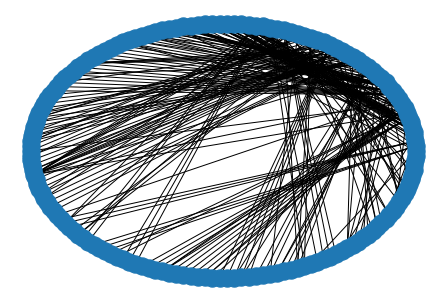

In [36]:
draw_graph(graph)

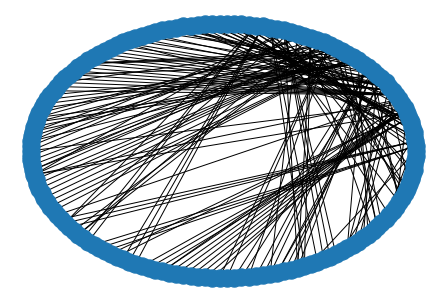

In [37]:
draw_graph(get_spanning_tree(graph))

In [38]:
graph = {i:{x for x in range(13) if x != i} for i in range(13)}
print(number_of_edges(graph))
print(number_of_edges(get_spanning_tree(graph)))

78
12


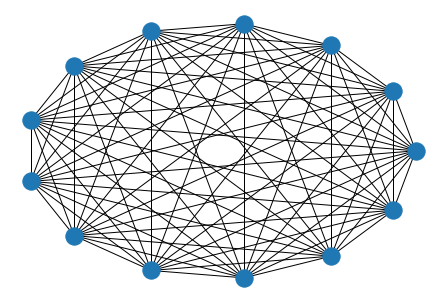

In [39]:
draw_graph(graph)

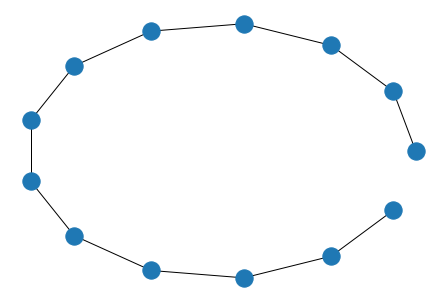

In [40]:
draw_graph(get_spanning_tree(graph))